In [1]:
import threading

# Helper thread to avoid the Spark StreamingContext from blocking Jupyter
        
class StreamingThread(threading.Thread):
    def __init__(self, ssc):
        super().__init__()
        self.ssc = ssc
    def run(self):
        self.ssc.start()
        self.ssc.awaitTermination()
    def stop(self):
        print('----- Stopping... this may take a few seconds -----')
        self.ssc.stop(stopSparkContext=False, stopGraceFully=True)

In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
spark

### Load all logs for each channel in a seperate csv

In [4]:
data_folder = 'logs'

In [5]:
# data folder has two subfolders (first_channel and second_channel) each one contain the saved logs of a different channel

In [6]:
import json

data = []

for dirname, dirs, files in os.walk(data_folder):
    for file in files:
        # skip success files and .crc files
        if file.endswith('.crc') or file.startswith('_'):
            continue
        
        with open(f"{dirname}/{file}", 'r') as f:
            for line in f:
                data.append(json.loads(line))

In [7]:
len(data)

16045

In [8]:
# create a spark dataframe from list

In [9]:
df = spark.createDataFrame(data)
df.show(50)

+--------+--------------------+--------------------+--------------------+
| channel|            datetime|             message|            username|
+--------+--------------------+--------------------+--------------------+
|#cdawgva|2022-05-16T19:48:...|                 LUL|    thatguyagain_420|
|#cdawgva|2022-05-14T16:10:...| new ranked is crazy|        cashcatri123|
|#cdawgva|2022-05-14T16:10:...|wheres your shiel...|            samxdesu|
|#cdawgva|2022-05-14T16:10:...|     Apex rat legend|            aikunxxx|
|#cdawgva|2022-05-14T16:10:...|tungsten rank OME...|             kkowaru|
|#cdawgva|2022-05-14T16:10:...|connor wants to t...|   internalspiritlol|
|#cdawgva|2022-05-14T16:10:...|        play oubs xD|           trixplays|
|#cdawgva|2022-05-14T16:10:...|         exactly bro|           izzy_1784|
|#cdawgva|2022-05-14T16:10:...|we have Daiso her...|      gojirathegreen|
|#cdawgva|2022-05-14T16:10:...|    advanced ratting|     operator_verona|
|#cdawgva|2022-05-14T16:10:...|       

## Just a simple EDA

In [10]:
df_pandas = df.toPandas()

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
values = df.groupBy('channel').count()
values.show()

+-----------+-----+
|    channel|count|
+-----------+-----+
|   #cdawgva| 8405|
|#doublelift| 7640|
+-----------+-----+



In [13]:
labels_counts = df_pandas["channel"].value_counts().sort_values()

(array([0, 1]), [Text(0, 0, '#doublelift'), Text(0, 1, '#cdawgva')])

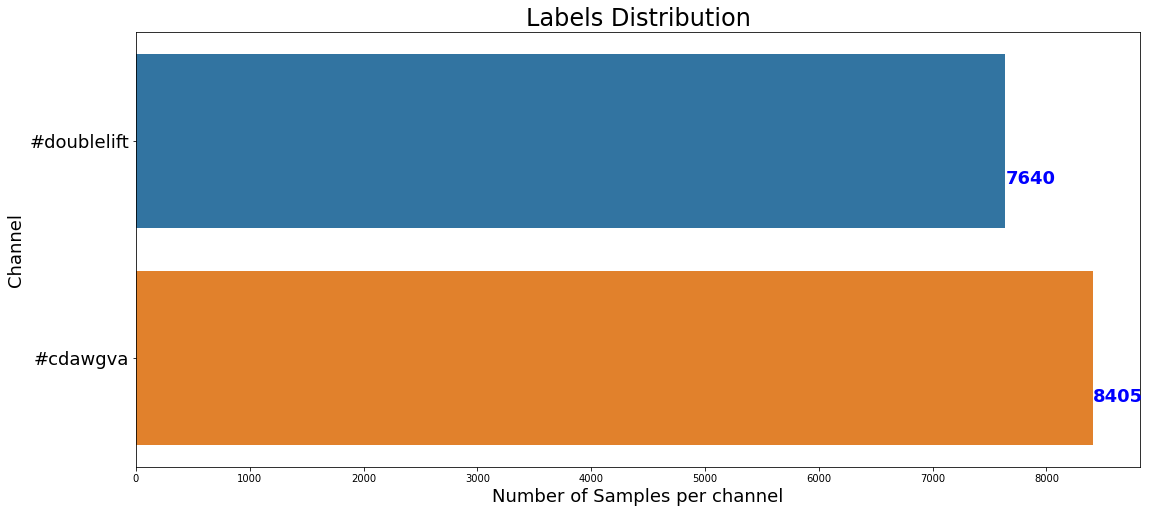

In [14]:
plt.figure(figsize=(18,8))
ax= sns.barplot(labels_counts, labels_counts.index)

plt.title("Labels Distribution", fontsize=24)
plt.ylabel('Channel', fontsize=18)
plt.xlabel('Number of Samples per channel', fontsize=18)

#adding the text labels
rects = ax.patches
for i, v in enumerate(labels_counts):
    ax.text(v + 3, i + .2, str(v), color='blue', fontweight='bold', fontsize=18)

plt.yticks(fontsize=18)

In [15]:
df_pandas.groupby('channel')['username'].nunique()

channel
#cdawgva       2359
#doublelift    1774
Name: username, dtype: int64

(array([0, 1]), [Text(0, 0, '#cdawgva'), Text(0, 1, '#doublelift')])

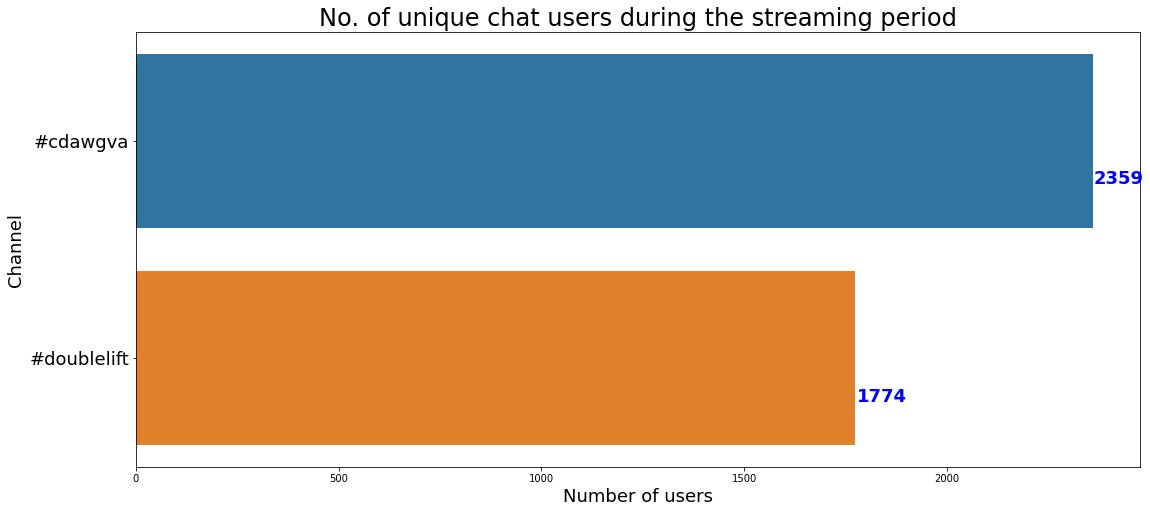

In [16]:
# number of users per channel

users_per_channel = df_pandas.groupby('channel')['username'].nunique()

plt.figure(figsize=(18,8))
ax= sns.barplot(users_per_channel, users_per_channel.index)

plt.title("No. of unique chat users during the streaming period", fontsize=24)
plt.ylabel('Channel', fontsize=18)
plt.xlabel('Number of users', fontsize=18)

#adding the text labels
rects = ax.patches
for i, v in enumerate(users_per_channel):
    ax.text(v + 3, i + .2, str(v), color='blue', fontweight='bold', fontsize=18)

plt.yticks(fontsize=18)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'orbitalforceyt'),
  Text(0, 1, 'nightbot'),
  Text(0, 2, 'xerivv'),
  Text(0, 3, 'kumo_ish'),
  Text(0, 4, 'hirosenen')])

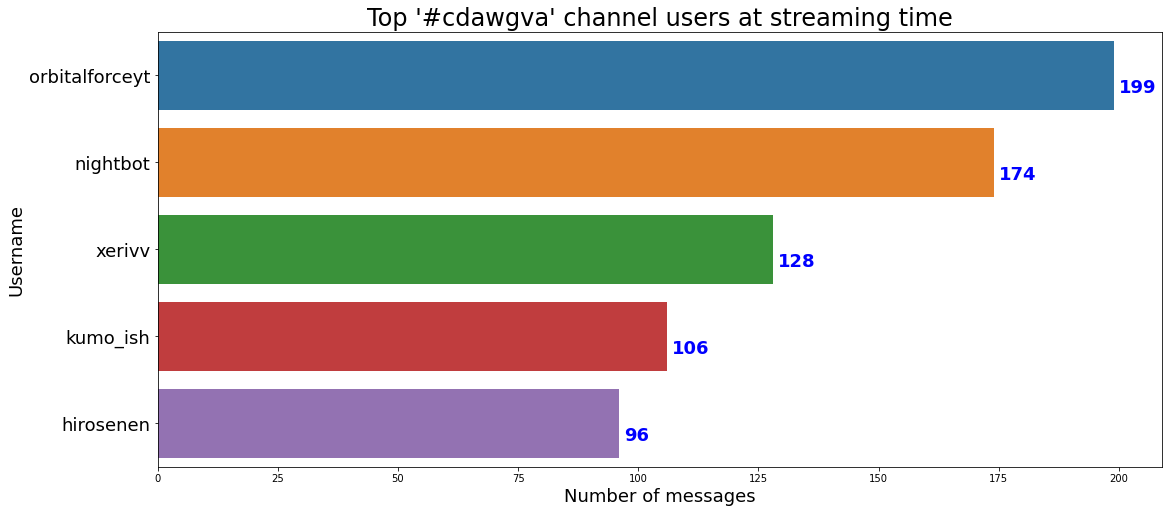

In [17]:
# frequent users per channel

channel_1_users = df_pandas[df_pandas["channel"] == "#cdawgva"]["username"].value_counts().sort_values()[::-1][:5]

plt.figure(figsize=(18,8))
ax= sns.barplot(channel_1_users, channel_1_users.index)

plt.title("Top '#cdawgva' channel users at streaming time", fontsize=24)
plt.ylabel('Username', fontsize=18)
plt.xlabel('Number of messages', fontsize=18)

#adding the text labels
rects = ax.patches
for i, v in enumerate(channel_1_users):
    ax.text(v + 1, i + .2, str(v), color='blue', fontweight='bold', fontsize=18)

plt.yticks(fontsize=18)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'carrywurst420'),
  Text(0, 1, 'raslerl'),
  Text(0, 2, 'xbonexs'),
  Text(0, 3, 'oblivion862'),
  Text(0, 4, 'whywhywhyquestionmark')])

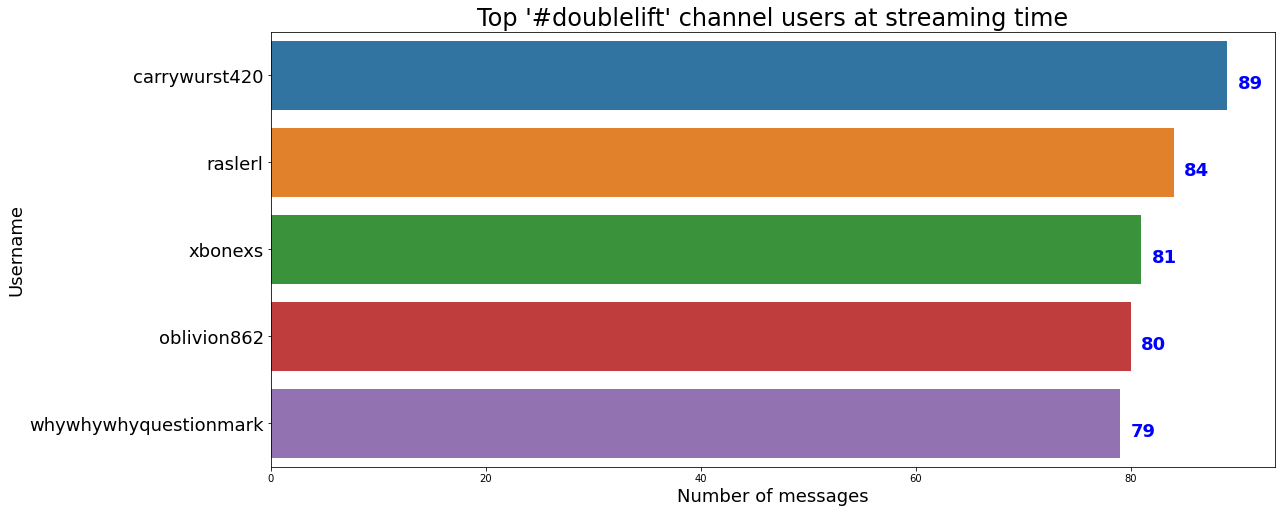

In [18]:
# frequent users per channel

channel_2_users = df_pandas[df_pandas["channel"] == "#doublelift"]["username"].value_counts().sort_values()[::-1][:5]

plt.figure(figsize=(18,8))
ax= sns.barplot(channel_2_users, channel_2_users.index)

plt.title("Top '#doublelift' channel users at streaming time", fontsize=24)
plt.ylabel('Username', fontsize=18)
plt.xlabel('Number of messages', fontsize=18)

#adding the text labels
rects = ax.patches
for i, v in enumerate(channel_2_users):
    ax.text(v + 1, i + .15, str(v), color='blue', fontweight='bold', fontsize=18)

plt.yticks(fontsize=18)

In [19]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def word_counts(messages):
    word_freq = {}
    
    for msg in messages:
        tokens = word_tokenize(msg.lower())
        for token in tokens:
            if token in stop_words or len(token)<=2:
                continue
            word_freq[token] = word_freq.get(token,0) + 1
    
    return sorted(word_freq.items(), key=lambda item: item[1], reverse=True)

In [20]:
## frequent words in each channel
channel_1_messages = list(df_pandas[df_pandas["channel"] == "#cdawgva"]["message"])

channel_2_messages = list(df_pandas[df_pandas["channel"] == "#doublelift"]["message"])

In [21]:
freqs = word_counts(channel_1_messages)[:10]
words = [i[0] for i in freqs]
counts = [i[1] for i in freqs]

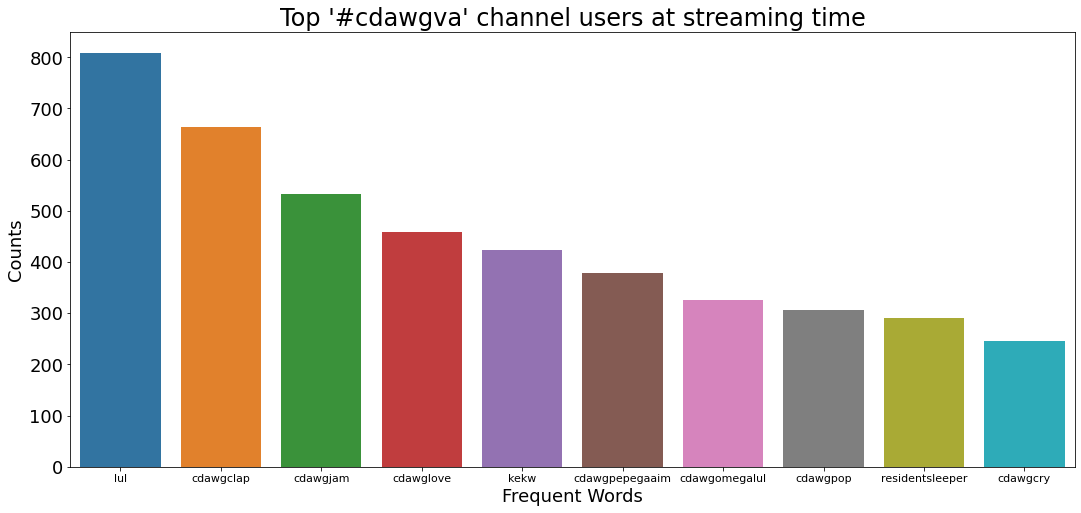

In [22]:
plt.figure(figsize=(18,8))
ax= sns.barplot(words, counts)

plt.title("Top '#cdawgva' channel users at streaming time", fontsize=24)
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Frequent Words', fontsize=18)

# #adding the text labels
# rects = ax.patches
# for i, v in enumerate(channel_2_users):
#     ax.text(v + 1, i + .15, str(v), color='blue', fontweight='bold', fontsize=18)

plt.yticks(fontsize=18)

plt.xticks(fontsize=11)
plt.savefig('common.png')

In [23]:
freqs = word_counts(channel_2_messages)[:10]
words = [i[0] for i in freqs]
counts = [i[1] for i in freqs]

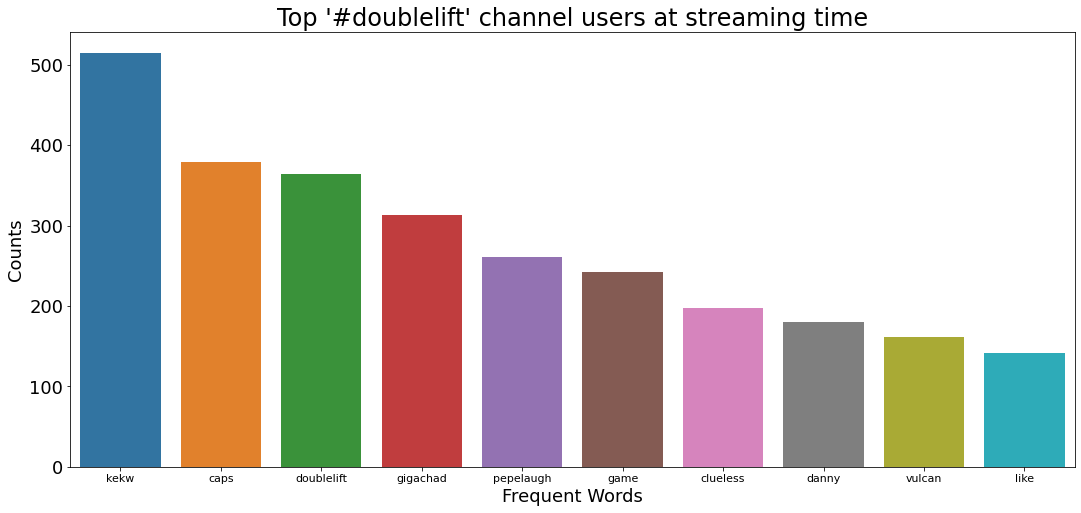

In [24]:
plt.figure(figsize=(18,8))
ax= sns.barplot(words, counts)

plt.title("Top '#doublelift' channel users at streaming time", fontsize=24)
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Frequent Words', fontsize=18)

# #adding the text labels
# rects = ax.patches
# for i, v in enumerate(channel_2_users):
#     ax.text(v + 1, i + .15, str(v), color='blue', fontweight='bold', fontsize=18)

plt.yticks(fontsize=18)

plt.xticks(fontsize=11)
plt.savefig('common.png')

In [25]:
# extract common emoji in text
import emoji

def extract_emojis(s):
    return set([c for c in s if c in emoji.UNICODE_EMOJI['en']])

In [26]:
def emoji_counts(messages):
    
    emoji_freqs = {}
    unique_emoji = extract_emojis(messages.lower())
    
    tokens = word_tokenize(messages)
    
    for token in tokens:
        if token in unique_emoji:
            emoji_freqs[token] = emoji_freqs.get(token,0)+1
    
    return sorted(emoji_freqs.items(), key=lambda item: item[1], reverse=True)

In [27]:
messages = " ".join([i for i in channel_1_messages])
emoji_counts(messages)

[('😂', 4),
 ('🐀', 3),
 ('💀', 2),
 ('👍', 2),
 ('👋', 2),
 ('🙏', 1),
 ('👌', 1),
 ('🤨', 1),
 ('♥', 1),
 ('\U0001f90c', 1),
 ('😴', 1),
 ('🌃', 1)]

# Model Development

In [28]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel# regular expression tokenizer

Tokenizer = Tokenizer(inputCol="message", outputCol="words")# stop words
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(list(stop_words))
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.0)

In [29]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString

label_stringIdx = StringIndexer(inputCol = "channel", outputCol = "label")
idx_to_label = IndexToString(inputCol="label", outputCol="predicted_label")

pipeline = Pipeline(stages=[Tokenizer, stopwordsRemover, countVectors, label_stringIdx, lr, idx_to_label])

#pipelineFit = pipeline.fit(df)
#df_transformed = pipelineFit.transform(df)
#df_transformed.show(5)

In [30]:
#drop datetime feature
df = df.drop("datetime")

In [31]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed = 0)
print(f"No. of training samples = {train_data.count()}")
print(f"No. of test samples = {test_data.count()}")

No. of training samples = 12778
No. of test samples = 3267


In [36]:
#lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.0)
trained_pipeline = pipeline.fit(train_data)

predictions = trained_pipeline.transform(test_data)

predictions.filter(predictions['prediction'] == 0) \
    .select("message","username","channel","label","prediction","predicted_label") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-------------------+--------+-----+----------+---------------+
|                       message|           username| channel|label|prediction|predicted_label|
+------------------------------+-------------------+--------+-----+----------+---------------+
|KonCha KonCha KonCha KonCha...|    rainymidnights_|#cdawgva|  0.0|       0.0|       #cdawgva|
|POGGERS GOD GAMER POGGERS G...|of_course_buttercup|#cdawgva|  0.0|       0.0|       #cdawgva|
|GlitchCat PowerUpL GlitchCa...|          wolfish__|#cdawgva|  0.0|       0.0|       #cdawgva|
|ironmouseWiggly cdawgJam ir...|             iveedo|#cdawgva|  0.0|       0.0|       #cdawgva|
|Lilimaruriri (aka DOOMbunny...|           nightbot|#cdawgva|  0.0|       0.0|       #cdawgva|
|Lilimaruriri (aka DOOMbunny...|           nightbot|#cdawgva|  0.0|       0.0|       #cdawgva|
|Lilimaruriri (aka DOOMbunny...|           nightbot|#cdawgva|  0.0|       0.0|       #cdawgva|
|Lilimaruriri (aka DOOMbunny...|           nightbo

In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="prediction")
evaluator.evaluate(predictions)

1.0

In [34]:
## Saving final model

In [35]:
trained_pipeline.write().overwrite().save('models/channel_classifier')